<b><font size='6'>Assignment 6<br>Fake news detection</font></b>

**BDT ILV bds19: Big Data Technologien ILV**  
**Data Science & Business Analytics**

Author: Thomas Schrittwieser, DS191004  
Date: 2020-12-26

# Task
The aim is to classify news as accurately as possible into fake or real news. 
* Statistics on text length, number of words, average word length, etc. can also be interesting.
* In addition, further (more complex) key figures based on predefined libraries are available, such as Flesch-Kincaid-Readability from [textstat](https://pypi.org/project/textstat/).
* The analysis of the text itself (via TF-IDF or Word2Vec) is also possible.


Kaggle description of the dataset: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset


---

# General steps

In [1]:
# import libraries
import numpy as np
import pandas as pd

import warnings
import multiprocessing as mp

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import textstat

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
# read data from HDFS or from local files
# data_from_HDFS = 1: read data from HDFS
# data_from_HDFS = 0: read data from local files
data_from_HDFS = 0

# set seed
SEED = 1234

# Number of usable cpu cores
NUM_CORES = mp.cpu_count()

In [3]:
# matplotlib styles
%matplotlib inline
plt.style.use('seaborn')

# ignore warnings
warnings.filterwarnings('ignore')

# Read data

In [4]:
if data_from_HDFS == 1:
    # read data from HDFS
    import findspark
    findspark.init()

    from pyspark.sql import SparkSession
    
    # create sparkSession
    spark = SparkSession.builder.appName('jupyter').getOrCreate()
    #spark = SparkSession.builder.appName('jupyter').master('spark://hadoop.priebe.io:7077').getOrCreate()
    #sc = spark.sparkContext
    
    # read datasets
    df_fake = spark.read.format('csv') \
        .option('header', 'true') \
        .option('inferSchema', 'true') \
        .load('hdfs://hadoop.priebe.io:9000/user/lbpriebe/fake_news/')

    df_true = spark.read.format('csv') \
        .option('header', 'true') \
        .option('inferSchema', 'true') \
        .load('hdfs://hadoop.priebe.io:9000/user/lbpriebe/true_news/')
    
    # convert the dataframe to pandas dataframe
    df_fake = df_fake.toPandas()
    df_true = df_true.toPandas()
    
else:
    # read data from local file
    df_fake = pd.read_csv('./data/fake_news.csv', encoding='latin')
    df_true = pd.read_csv('./data/true_news.csv', encoding='latin')

In [5]:
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obamaâs Na...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [7]:
# Concise summary of the DataFrame
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:
# Concise summary of the DataFrame
df_fake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [9]:
# Show Null-Values
df_true.isnull().sum().sort_values(ascending=False)

title      0
text       0
subject    0
date       0
dtype: int64

In [10]:
# Show Null-Values
df_fake.isnull().sum().sort_values(ascending=False)

title      0
text       0
subject    0
date       0
dtype: int64

In [11]:
# Drop the instances with null-values
# When you read the data from HDFS, the dataframe df_fake contains 
# 8 instances with null values. These instances will be dropped.
df_fake.dropna(axis=0, inplace=True)

In [12]:
# dimensionality of the dataframes
print('Dimensionality of DataFrames:')
print(f' - True News: {df_true.shape[0]} x {df_true.shape[1]}')
print(f' - Fake News: {df_fake.shape[0]} x {df_fake.shape[1]}')

print('\nRatio True News / Fake News:')
print(f' - True News: {(df_true.shape[0]/(df_true.shape[0]+df_fake.shape[0])*100):.1f}%')
print(f' - Fake News: {(df_fake.shape[0]/(df_true.shape[0]+df_fake.shape[0])*100):.1f}%')

Dimensionality of DataFrames:
 - True News: 21417 x 4
 - Fake News: 23481 x 4

Ratio True News / Fake News:
 - True News: 47.7%
 - Fake News: 52.3%


In [13]:
# unique subjects of dataframes
fake_subjects = df_fake['subject'].unique()
true_subjects = df_true['subject'].unique()

# number of entries per subject
fake_subjects_cnt = df_fake.groupby(by='subject').count()['title']
true_subjects_cnt = df_true.groupby(by='subject').count()['title']

In [14]:
# Define color palette for the plots
no_colors = len(true_subjects)
colors_true = plt.cm.jet(np.linspace(0,1,no_colors))

no_colors = len(fake_subjects)
colors_fake = plt.cm.jet(np.linspace(0,1,no_colors))

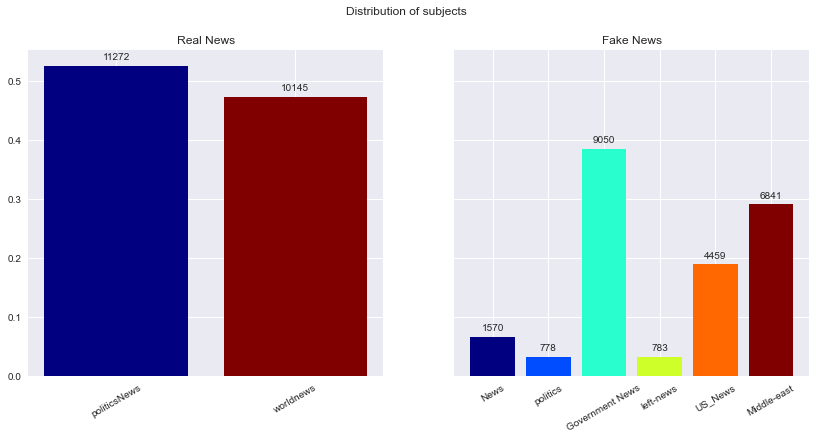

In [15]:
# plot subject ratio 
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (14, 6))

ax1.bar(x = true_subjects, height=true_subjects_cnt/df_true.shape[0], color=colors_true)
ax2.bar(x = fake_subjects, height=fake_subjects_cnt/df_fake.shape[0], color=colors_fake)
ax1.set_title('Real News')
ax2.set_title('Fake News')
ax1.tick_params(axis='x', labelrotation=30)
ax2.tick_params(axis='x', labelrotation=30)
plt.suptitle('Distribution of subjects')

for i, v in enumerate(true_subjects):
    ax1.text(true_subjects[i], true_subjects_cnt[i]/df_true.shape[0]+0.01, str(true_subjects_cnt[i]), ha='center')

for i, v in enumerate(fake_subjects):
    ax2.text(fake_subjects[i], fake_subjects_cnt[i]/df_fake.shape[0]+0.01, str(fake_subjects_cnt[i]), ha='center');

# Separate the publisher

In [16]:
def separate_publisher(df):
    #First Creating list of index that do not have publication part
    unknown_publishers = []
    for index, row in enumerate(df['text'].values):
        try:
            record = row.split(' - ', maxsplit=1)
            #if no text part is present, following will give error
            record[1]
            #if len of publication part is greater than 260
            #following will give error, ensuring no text having "-" in between is counted
            assert(len(record[0]) < 260)
        except:
            unknown_publishers.append(index)
    
    #Seperating Publication info, from actual text
    publisher = []
    tmp_text = []
    for index, row in enumerate(df['text'].values):
        if index in unknown_publishers:
            #Add unknown of publisher not mentioned
            tmp_text.append(row)
            publisher.append('Unknown')
            continue
        record = row.split(' - ', maxsplit=1)
        publisher.append(record[0])
        tmp_text.append(record[1])
        
    # Replace existing text column with new text
    # add seperate column for publication info
    df['publisher'] = publisher
    df['text'] = tmp_text
    
    return df

In [17]:
# separate the publisher at df_true
df_true = separate_publisher(df_true)

df_true.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [18]:
# separate the publisher at df_fake
df_fake = separate_publisher(df_fake)

df_fake.head()

,title,text,subject,date,publisher
0,Donald Trump Sends Out Embarrassing New Yearâ...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Unknown
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Unknown
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Unknown
3,Trump Is So Obsessed He Even Has Obamaâs Na...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",Unknown
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",Unknown


# Drop rows with empty text-feature

In [19]:
# function that checks if a dataframe has rows with empty text-feature
def rows_with_empty_text(df):
    empty_rows_idx = []
    for index, text in enumerate(df['text'].values):
        if str(text).strip() == '':
            empty_rows_idx.append(index)
    return empty_rows_idx

In [20]:
# check df_true, if rows with empty text-feature exists
empty_rows_true_idx = rows_with_empty_text(df_true)

# check df_fake, if rows with empty text-feature exists
empty_rows_fake_idx = rows_with_empty_text(df_fake)

print('Number of rows with empty text:')
print(f' - Real News: {len(empty_rows_true_idx)}')
print(f' - Fake News: {len(empty_rows_fake_idx)}')

Number of rows with empty text:
 - Real News: 1
 - Fake News: 630


In [21]:
# dropping rows with empty text-feature
df_true.drop(empty_rows_true_idx, axis=0, inplace=True)
df_fake.drop(empty_rows_fake_idx, axis=0, inplace=True)

del empty_rows_true_idx, empty_rows_fake_idx

# Concatenate the dataframes

In [22]:
# Create a new feature named class which represents if the news are fake or not
# fake news: 0
# true news: 1
df_fake['class'] = 0
df_true['class'] = 1

In [23]:
# concatenate the dataframes
df = pd.concat([df_fake, df_true],axis=0)

In [24]:
print('\nDistribution of fake news and real news')
print(f' - Real News: {(df_true.shape[0]/(df_true.shape[0]+df_fake.shape[0])*100):.1f}%')
print(f' - Fake News: {(df_fake.shape[0]/(df_true.shape[0]+df_fake.shape[0])*100):.1f}%')


Distribution of fake news and real news
 - Real News: 48.4%
 - Fake News: 51.6%


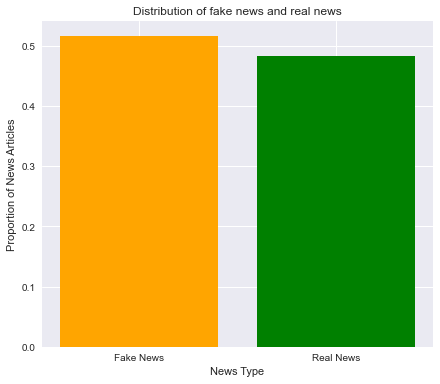

In [25]:
total_len = len(df_fake) + len(df_true)

plt.figure(figsize=(7, 6))
plt.bar('Fake News', len(df_fake) / total_len, color='orange')
plt.bar('Real News', len(df_true) / total_len, color='green')
plt.title('Distribution of fake news and real news')
plt.xlabel('News Type')
plt.ylabel('Proportion of News Articles');

# Textstat

In [26]:
def word_count(text):
    return textstat.lexicon_count(text, removepunct=True)

In [27]:
def syllable_count(text):
    return textstat.syllable_count(text)

In [28]:
def flesch_reading_ease_score(text):
    return textstat.flesch_reading_ease(text)

In [29]:
df['words'] = df['text'].apply(word_count)

In [30]:
df['syllables'] = df['text'].apply(syllable_count)

In [31]:
df['flesch_rdg_easy_score'] = df['text'].apply(flesch_reading_ease_score)

In [32]:
print('\nFake News - Descriptive statistics:\n')
df[df['class']==0].describe()


Fake News - Descriptive statistics:



,class,words,syllables,flesch_rdg_easy_score
count,22851.0,22851.000000,22851.000000,22851.00000
mean,0.0,434.237539,668.008621,39.87354
std,0.0,407.137262,656.598063,38.19596
min,0.0,1.000000,1.000000,-2078.39000
25%,0.0,254.000000,384.500000,31.02500
50%,0.0,369.000000,560.000000,44.41000
75%,0.0,510.000000,778.000000,55.37000
max,0.0,8122.000000,13533.000000,121.22000


In [33]:
print('\nReal News - Descriptive statistics:\n')
df[df['class']==1].describe()


Real News - Descriptive statistics:



,class,words,syllables,flesch_rdg_easy_score
count,21416.0,21416.000000,21416.000000,21416.000000
mean,1.0,381.423422,604.653063,32.874972
std,0.0,273.435491,430.611117,19.613949
min,1.0,16.000000,30.000000,-547.660000
25%,1.0,144.000000,228.000000,26.310000
50%,1.0,356.000000,563.000000,36.290000
75%,1.0,520.000000,823.000000,44.217500
max,1.0,5168.000000,7529.000000,83.150000


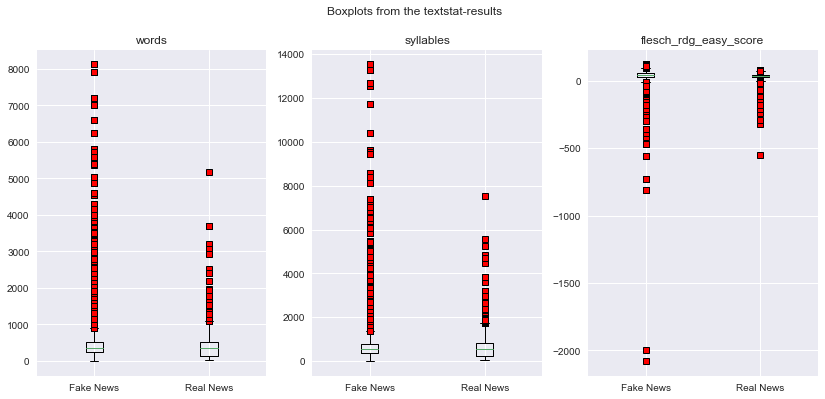

In [34]:
# draw boxplots of textstat
features = ['words', 'syllables', 'flesch_rdg_easy_score']

plot_size = (14, 6)

# marker for outliers
red_square = dict(markerfacecolor='r', marker='s')

labels = ['Fake News', 'Real News']

fig, ax = plt.subplots(1, len(features), figsize = plot_size)
fig.suptitle(f'Boxplots from the textstat-results')

for i, feature in enumerate(features):
    a_fake = df[df['class']==0][feature]
    a_true = df[df['class']==1][feature]
    ax[i].boxplot([a_fake, a_true], positions=[1,2], labels = labels, flierprops=red_square)
    ax[i].set_title(feature)
    ax[i].set(xticklabels=labels)

# Data Cleansing

In [35]:
# combining title and text
df['text'] = df['title'] + ' ' + df['text']

In [36]:
# Function for text cleansing
def word_opt(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('\\W',' ',text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('[^a-z]', ' ', text)
    text = re.sub(r'\s+', ' ', text, flags=re.I) # Substituting multiple spaces with single space
    text = re.sub(r'^\ {1}| \ {1}$', '', text) # Remove all spaces at the beginning and the end of a string
    return text

In [37]:
# Cleansing text-feature
df['text'] = df['text'].apply(word_opt)

In [38]:
df['text']

0        donald trump sends out embarrassing new year s...
1        drunk bragging trump staffer started russian c...
2        sheriff david clarke becomes an internet joke ...
3        trump is so obsessed he even has obama s name ...
4        pope francis just called out donald trump duri...
                               ...                        
21412    fully committed nato backs new u s approach on...
21413    lexisnexis withdrew two products from chinese ...
21414    minsk cultural hub becomes haven from authorit...
21415    vatican upbeat on possibility of pope francis ...
21416    indonesia to buy billion worth of russian jets...
Name: text, Length: 44267, dtype: object

In [39]:
# Drop unnecessary features
# title, subject, date
df.drop(['title', 'subject', 'date'], axis=1, inplace=True)

In [40]:
df.isnull().sum().sort_values(ascending=False)

text                     0
publisher                0
class                    0
words                    0
syllables                0
flesch_rdg_easy_score    0
dtype: int64

# Train-Test-Split

In [41]:
df.head()

,text,publisher,class,words,syllables,flesch_rdg_easy_score
0,donald trump sends out embarrassing new year s...,Unknown,0,492,716,34.56
1,drunk bragging trump staffer started russian c...,Unknown,0,305,475,43.36
2,sheriff david clarke becomes an internet joke ...,Unknown,0,579,866,50.50
3,trump is so obsessed he even has obama s name ...,Unknown,0,441,696,26.71
4,pope francis just called out donald trump duri...,Unknown,0,420,588,59.98


In [42]:
X = df['text'].values
y = df['class'].values

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = SEED)

# Converting text to vectors

In [44]:
tvec = TfidfVectorizer(max_features=200000, ngram_range=(1, 3))

XV_train = tvec.fit_transform(X_train)
XV_test=tvec.transform(X_test)

In [45]:
#vectorizer = TfidfVectorizer()

#XV_train = vectorizer.fit_transform(X_train)
#XV_test=vectorizer.transform(X_test)

# Logistic Regression

In [46]:
lr = LogisticRegression()
lr.fit(XV_train, y_train)

LogisticRegression()

In [47]:
lr_pred = lr.predict(XV_test)

In [48]:
print('\nLogistic Regression')
print(f' - Mean Accuracy: {(lr.score(XV_test, y_test)):.4f}')
print(f' - AUC Score:     {(roc_auc_score(y_test, lr_pred)):.4f}')


Logistic Regression
 - Mean Accuracy: 0.9852
 - AUC Score:     0.9854


In [49]:
# Create Confusion Matrix
def confusion_matrix(y_pred, y_test, model_name):
    # y_pred: pandas Series with the predicted values
    # y_test: pandas Series with the actual values
    # model_name: String

    conf_matrix = pd.crosstab(y_pred, y_test, rownames=['Predicted'], colnames=['Actual'])
       
    ax = plt.axes()
    sns.heatmap(conf_matrix, annot=True, fmt="0", ax = ax)
    ax.set_title(f'{model_name}\nConfusion Matrix');

    #print('\nConfusion Matrix - Logistic Regression:')
    #print(model_name)

In [50]:
# Create Classification Report
def class_report(y_test, y_pred, model_name, tn):
    # y_pred: pandas Series with the predicted values
    # y_test: pandas Series with the actual values
    # model_name: String
    # tn: list of target_names
    cr = classification_report(y_test, y_pred, target_names=tn)

    print(f'\n{model_name} - Classification Report\n')
    print(cr)
    print(' '*6 + f'Cohens \u03BA\t     {round(metrics.cohen_kappa_score(y_test, y_pred),2)}')

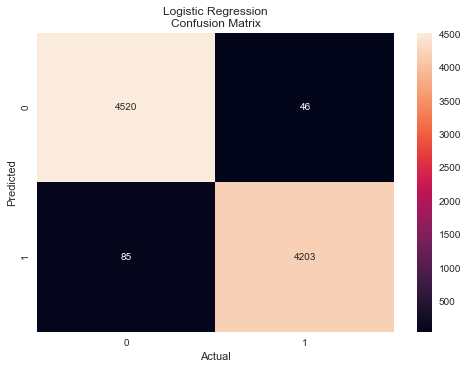

In [51]:
confusion_matrix(lr_pred, y_test, 'Logistic Regression')

In [52]:
tn = ['Fake News', 'Real News']
class_report(y_test, lr_pred, 'Logistic Regression', tn=tn)


Logistic Regression - Classification Report

              precision    recall  f1-score   support

   Fake News       0.99      0.98      0.99      4605
   Real News       0.98      0.99      0.98      4249

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854

      Cohens κ	     0.97


# Decision Tree

In [53]:
dt = DecisionTreeClassifier(random_state=SEED)
dt.fit(XV_train, y_train)

DecisionTreeClassifier(random_state=1234)

In [54]:
dt_pred = dt.predict(XV_test)

In [55]:
print('\nDecision Tree')
print(f' - Mean Accuracy: {(dt.score(XV_test, y_test)):.4f}')
print(f' - AUC Score:     {(roc_auc_score(y_test, dt_pred)):.4f}')


Decision Tree
 - Mean Accuracy: 0.9663
 - AUC Score:     0.9662


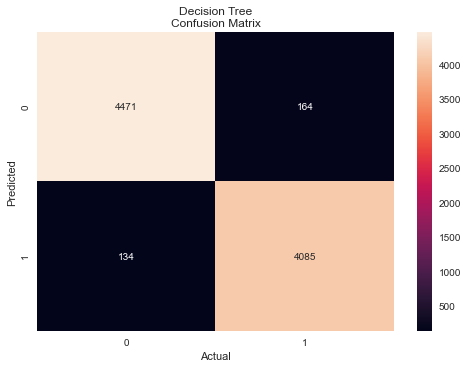

In [56]:
confusion_matrix(dt_pred, y_test, 'Decision Tree')

In [57]:
class_report(y_test, dt_pred, 'Decision Tree', tn=tn)


Decision Tree - Classification Report

              precision    recall  f1-score   support

   Fake News       0.96      0.97      0.97      4605
   Real News       0.97      0.96      0.96      4249

    accuracy                           0.97      8854
   macro avg       0.97      0.97      0.97      8854
weighted avg       0.97      0.97      0.97      8854

      Cohens κ	     0.93


# Random Forest

In [58]:
rf = RandomForestClassifier(random_state=SEED, n_jobs=NUM_CORES)
rf.fit(XV_train, y_train)

RandomForestClassifier(n_jobs=8, random_state=1234)

In [59]:
rf_pred = rf.predict(XV_test)

In [60]:
print('\nRandom Forest')
print(f' - Mean Accuracy: {(rf.score(XV_test, y_test)):.4f}')
print(f' - AUC Score:     {(roc_auc_score(y_test, rf_pred)):.4f}')


Random Forest
 - Mean Accuracy: 0.9884
 - AUC Score:     0.9884


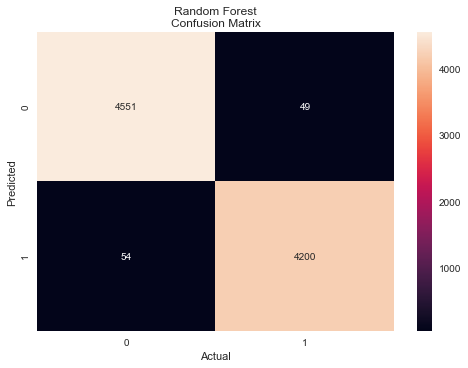

In [61]:
confusion_matrix(rf_pred, y_test, 'Random Forest')

In [62]:
class_report(y_test, rf_pred, 'Random Forest', tn=tn)


Random Forest - Classification Report

              precision    recall  f1-score   support

   Fake News       0.99      0.99      0.99      4605
   Real News       0.99      0.99      0.99      4249

    accuracy                           0.99      8854
   macro avg       0.99      0.99      0.99      8854
weighted avg       0.99      0.99      0.99      8854

      Cohens κ	     0.98
